# **Taxi Order Predictions**

**Background:** Sweet Lift Taxi company has historical data on taxi orders over time and wants to predict taxi orders in the future.  

**Purpose:** Build a time series model that minimizes RMSE when predicting the number of taxi orders in the next hour.  

**Techniques:** Seasonal decomposition, tuning time series linear regression and random forest regression with skforecast.  

**Sections:**  
* Import Packages and Data
* Prepare Data
* Time Series Model Tuning
* Conclusions and Business Application

## **Import Packages and Data**

In [229]:
# Import packages
import numpy as np
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [230]:
# Read data
taxi = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/taxi.csv', parse_dates=[0], index_col=[0])

In [231]:
# Print info
print(taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Index is datetime and only one column with number of taxi orders. There are no missing values.

In [232]:
# Display head
display(taxi.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [233]:
# Check dates are ordered
print('Dates are ordered in increasing time:')
print(f'{taxi.index.is_monotonic_increasing}')

Dates are ordered in increasing time:
True


### Initial data observations

The dataset contains taxi orders in 10-minute intervals. There is only one column with number of taxi orders and 26496 observations. There are no missing values. The data is ready for analysis.

## **Prepare Data**

### Check date order

In [234]:
# Check dates are increasing
print('Dates are ordered in increasing time:')
print(f'{taxi.index.is_monotonic_increasing}')

Dates are ordered in increasing time:
True


### Group time by hour

In [235]:
# Resample by hour
taxi = taxi.resample('1H').sum()

display(taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Dataframe is summed by hour.

## **Exploratory Analysis**

### Individual distributions

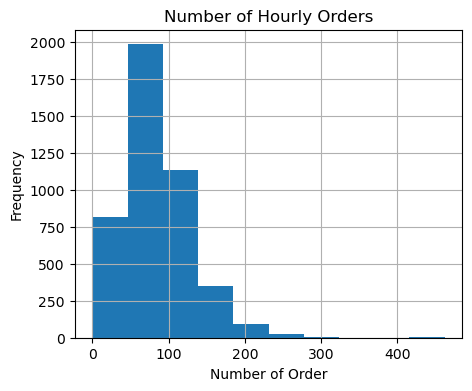

In [236]:
# Histogram of order number
plt.figure(figsize=(5, 4))

taxi['num_orders'].hist()

plt.title('Number of Hourly Orders')
plt.xlabel('Number of Order')
plt.ylabel('Frequency')

plt.show()

Number of orders by hour is left skewed, with most hours recieving 0 - 150 order and only a few hours recieving over 250 orders.

### Time series plot

In [237]:
# Calculate rolling mean and standard deviation by day
taxi['rolling_mean'] = taxi['num_orders'].rolling(24).mean()
taxi['std'] = taxi['num_orders'].shift().rolling(24).std()

display(taxi.sample(5))

,num_orders,rolling_mean,std
datetime,,,
2018-06-27 08:00:00,102,88.583333,27.979677
2018-06-07 04:00:00,83,76.041667,29.238617
2018-04-30 22:00:00,85,72.708333,34.726572
2018-03-07 22:00:00,127,58.083333,29.462824
2018-04-07 16:00:00,100,70.083333,38.125650


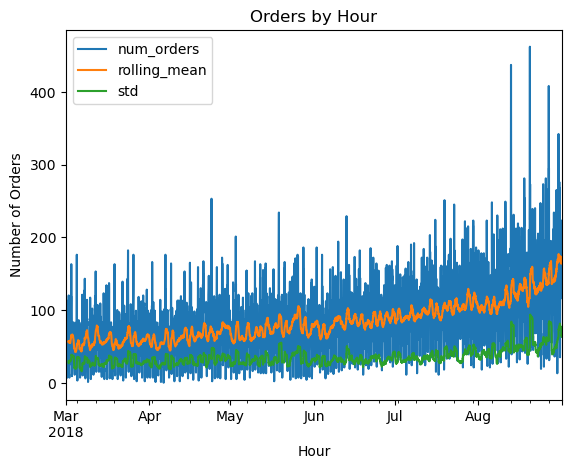

In [238]:
# Plot time series
taxi.plot()

plt.title('Orders by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

The graph shows evidence of both seasonality and an upward trend in number of taxi orders per hour. Both the mean and standard deviation increase over time, so this is a non-stationary timeseries.

### Plot seasonality and trend

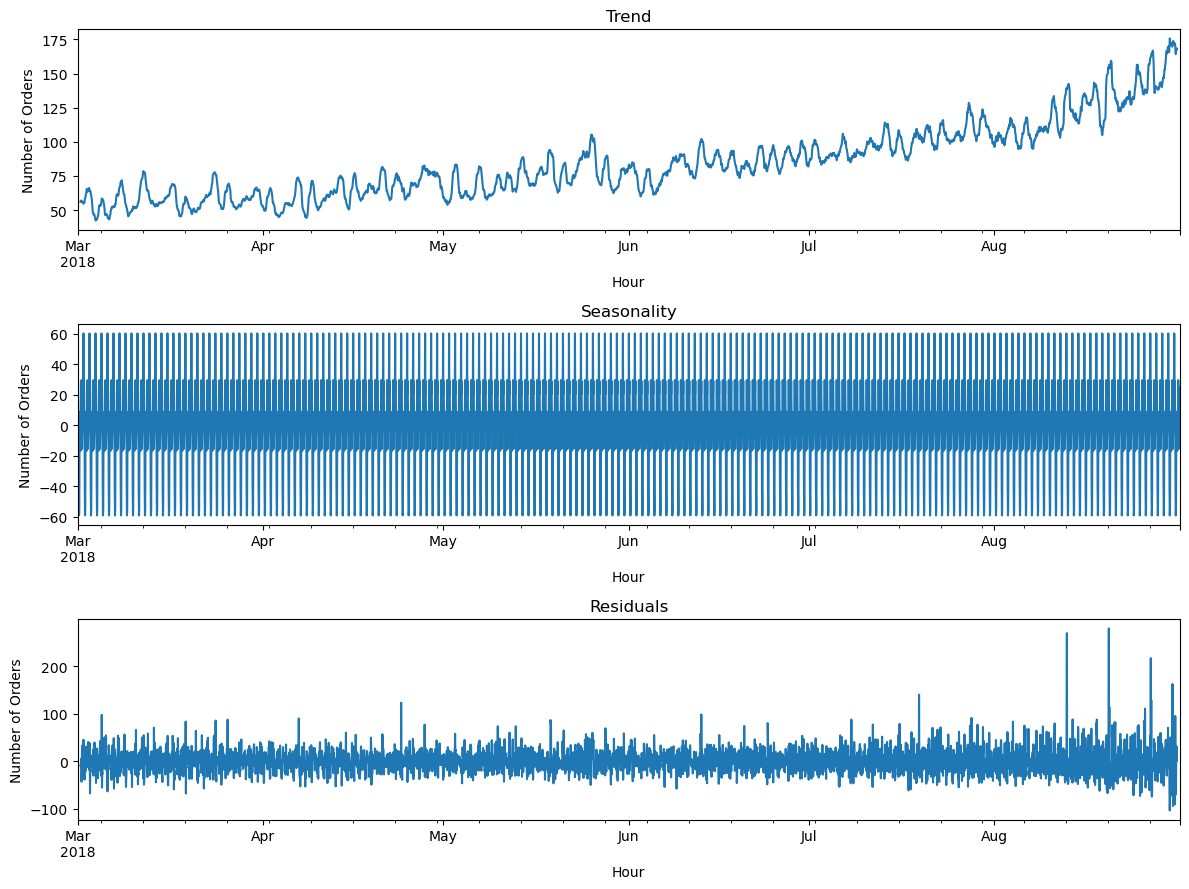

In [239]:
# Decompose data
decomposed = seasonal_decompose(taxi[['num_orders']])

# Plot trends
plt.figure(figsize=(12, 9))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.tight_layout()

plt.show()

There is a confirmed upward trend. Seasonality occurs in very short timeframes - possibly within the day.

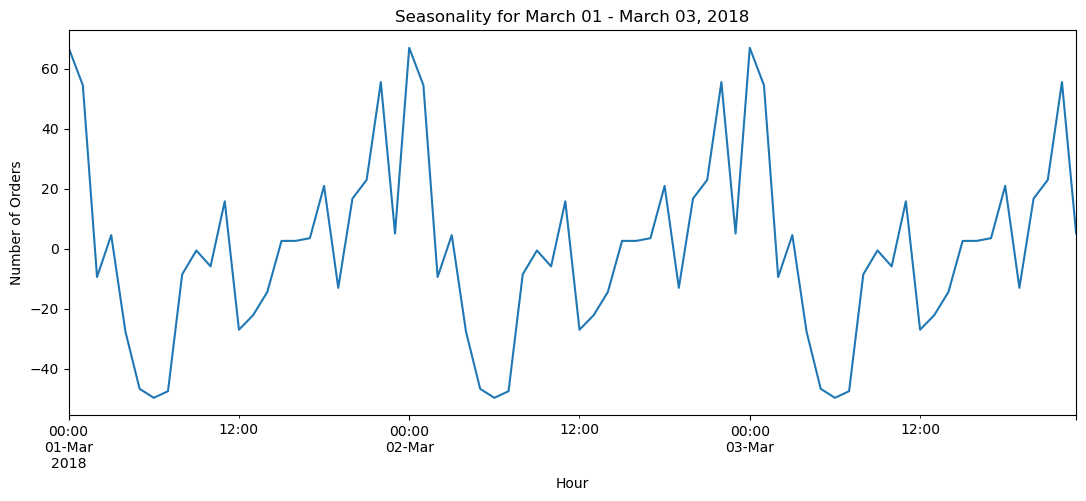

In [240]:
# Zoom in on 3 day seasonality
decomposed_3day = seasonal_decompose(taxi.loc['2018-03-01':'2018-03-03', 'num_orders'])

plt.figure(figsize=(13, 5))

decomposed_3day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for March 01 - March 03, 2018')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

Seasonality occurs within the day. Orders start low in the early morning and generally climb through the night.

### Exploratory analysis conclusions

Number of hourly orders range from 0 - 450, with most hours receiving 0 - 150 orders. The time series is non-stationary with an increasing mean and standard deviation over time. There is an upward trend and seasonality within the day.

## **Time Series Forecasting**

### Make features and target

In [241]:
# Add date features
taxi['year'] = taxi.index.year
taxi['month'] = taxi.index.month
taxi['day'] = taxi.index.day
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

taxi = taxi.dropna()

# Define features and target
features = taxi.drop(['num_orders', 'std'], axis=1)
target = taxi['num_orders']

print('Features:')
display(features.head())
print('Target:')
display(target.head().to_frame())

Features:


,rolling_mean,year,month,day,dayofweek,hour
datetime,,,,,,
2018-03-02 00:00:00,55.416667,2018,3,2,4,0
2018-03-02 01:00:00,56.875000,2018,3,2,4,1
2018-03-02 02:00:00,57.041667,2018,3,2,4,2
2018-03-02 03:00:00,56.958333,2018,3,2,4,3
2018-03-02 04:00:00,56.000000,2018,3,2,4,4


Target:


,num_orders
datetime,
2018-03-02 00:00:00,90
2018-03-02 01:00:00,120
2018-03-02 02:00:00,75
2018-03-02 03:00:00,64
2018-03-02 04:00:00,20


### Split train and test

In [242]:
# Create training and test sets
feat_train, feat_test, targ_train, targ_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)

print(f'Features Train shape: {feat_train.shape}')
print(f'Features Test shape: {feat_test.shape}')
print(f'Target Train shape: {targ_train.shape}')
print(f'Target Test shape: {targ_test.shape}')

Features Train shape: (3952, 6)
Features Test shape: (440, 6)
Target Train shape: (3952,)
Target Test shape: (440,)


Text(0, 0.5, 'Number of Orders')

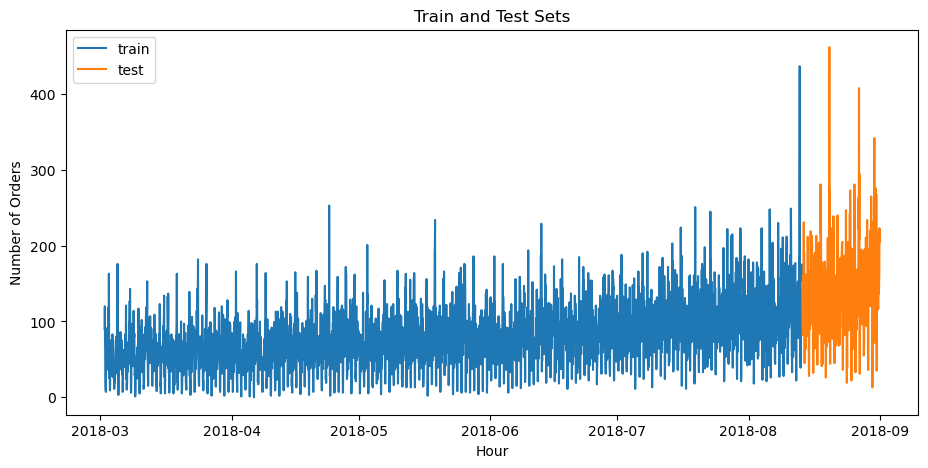

In [254]:
# Plot train and test
plt.figure(figsize=(11, 5))

plt.plot(targ_train, label='train')
plt.plot(targ_test, label='test')

plt.legend()

plt.title('Train and Test Sets')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

### Baseline model

In [244]:
# Use previous value to predict next value
pred_previous = targ_test.shift()
pred_previous.iloc[0] = targ_train.iloc[-1]

base_rmse = mean_squared_error(targ_test, pred_previous, squared=False)

print(f'Base RMSE: {base_rmse:.2f}')

Base RMSE: 58.86


### Linear Regression

In [253]:
# Tune regression to minimize rmse
best_lags = 0
best_rmse = base_rmse
best_predictions = []

feat_names = ['rolling_mean']

for lag in range(1, 100, 10):
    regression = ForecasterAutoreg(regressor=LinearRegression(), lags=lag)
    regression.fit(y=targ_train, exog=feat_train[feat_names])
    
    predictions = regression.predict(steps=len(targ_test), exog=feat_test[feat_names])
    rmse = mean_squared_error(targ_test, predictions, squared=False)
    
    if rmse < best_rmse:
        best_lags = lag
        best_rmse = rmse
        best_predictions = predictions

print(f'Best number of lags: {best_lags}')
print(f'Best RMSE Test: {best_rmse:.2f}')

Best number of lags: 41
Best RMSE Test: 0.00


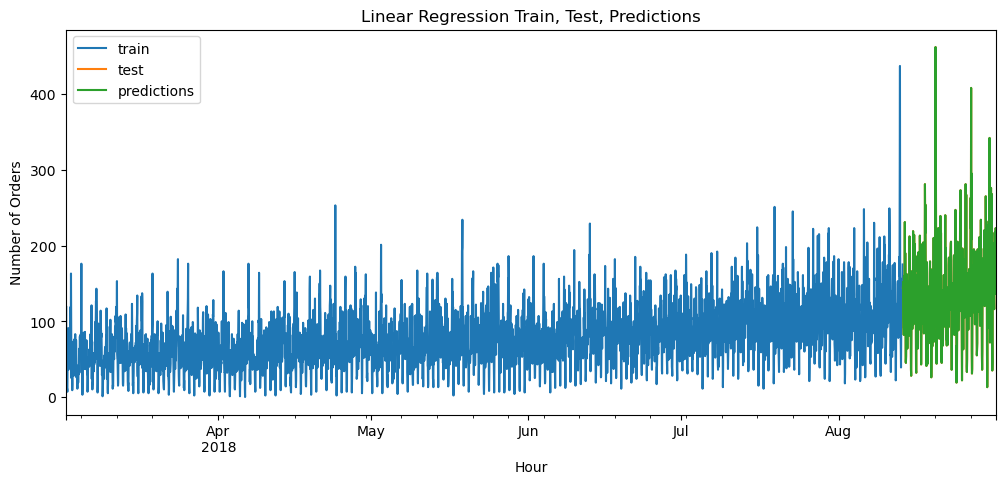

In [249]:
# Plot train, test, and predictions of best linear model
fig, ax = plt.subplots(figsize=(12, 5))

targ_train.plot(ax=ax, label='train')
targ_test.plot(ax=ax, label='test')
best_predictions.plot(ax=ax, label='predictions')

ax.legend()

plt.title('Linear Regression Train, Test, Predictions')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

#### Linear regression conclusions

Using a rolling mean of size 24 and 41 lag features, linear regression trained on the training set was able to achieve and RMSE of 0.00 on the test set. This represents perfect predictions of the test values.

### Random Forest

In [276]:
# Tune random forest lags and hyperparameters
forest = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123),
                           lags=10)

lags = range(10, 200, 40)

grid = {
    'n_estimators':[10, 50, 100, 150],
    'max_depth':[5, 10, 15]
}

regression_gsf = grid_search_forecaster(
    forecaster=forest,
    y=targ_train,
    param_grid=grid,
    lags_grid=lags,
    steps=len(targ_train),
    initial_train_size=3500,
    fixed_train_size = False,
    metric='mean_squared_error',
    refit=True,
    return_best=True,
    verbose=False
)

Number of models compared: 60.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 1101.8321608144947



The best forest had a max depth of 10 with 50 trees and 170 lag features. It achieved an mse of 1810.42 on the validation set.

In [278]:
# Fit best forest to training data with extra features
forest.fit(targ_train, exog=feat_train[['rolling_mean', 'year', 'day', 'month', 'hour']])

# Predict test set
predictions = forest.predict(steps=len(targ_test), exog=feat_test[['rolling_mean', 'year', 'day', 'month', 'hour']])

# Calculate RMSE of test and predictions
rmse = mean_squared_error(targ_test, predictions, squared=False)

print(f'Random Forest Test RMSE: {rmse:.2f}')

Random Forest Test RMSE: 39.32


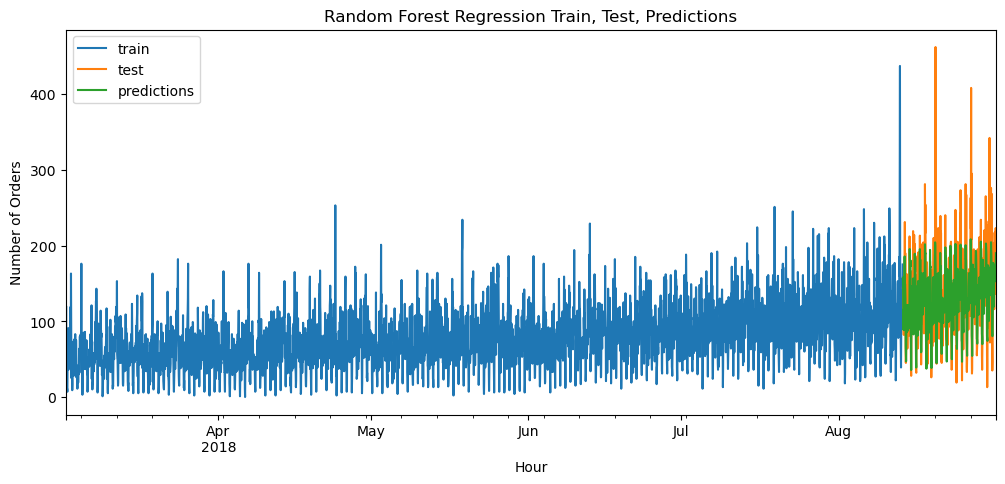

In [279]:
# Plot train, test, and predictions of best random forest
fig, ax = plt.subplots(figsize=(12, 5))

targ_train.plot(ax=ax, label='train')
targ_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')

ax.legend()

plt.title('Random Forest Regression Train, Test, Predictions')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')

plt.show()

#### Random forest conclusions

The tuned random forest was able to acheive and RMSE of 39.32 on the test set. This is far above the RMSE of the linear regression. Random forest regression was not able to predict future orders as well as linear regression.

## **Time Series Model Conclusions and Business Application**

Swift Lift Taxi Company wanted to predict the number of taxi orders in the next hour, using historical time series data. This was a non-stationary time series problem, with both mean and standard deviation increasing over time. Taxi orders had a general upward trend over time and seasonality by day.  

Both linear regression and random forest models were tuned to predict orders in the next hour. Linear regression with 41 lag variables was able to acheive the best model and make perfect predictions on the test set (RMSE = 0).  

Going forward, Swift Lift Taxi Company can use this regression model to predict how many orders they will receive in the next hour. They can use this information to post special promotions to attract more drivers during busy times and consumer promotions to attract more customers during slow times.